# Model SBC Report

In [1]:
import logging
import warnings
from pathlib import Path
from pprint import pprint
from time import time

import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg

from src.analysis import pymc3_analysis as pmanal
from src.analysis import sbc_analysis as sbcanal
from src.loggers import set_console_handler_level
from src.managers.model_cache_managers import Pymc3ModelCacheManager
from src.modeling import simulation_based_calibration_helpers as sbc
from src.project_enums import ModelFitMethod

In [2]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

set_console_handler_level(logging.WARNING)
pymc3_cache_dir = Path("..", "models", "modeling_cache", "pymc3_model_cache")

Parameters for papermill:

- `MODEL_NAME`: unique, identifiable name of the model
- `SBC_RESULTS_DIR`: directory containing results of many rounds of SBC
- `SBC_COLLATED_RESULTS`: path to collated simulation posteriors
- `SBC_UNIFORMITY_RESULTS`: path to results of the uniformity test
- `NUM_SIMULATIONS`: the number of simiulations; will be used to check that all results are found
- `CONFIG_PATH`: path to the model configuration file
- `FIT_METHOD`: model fitting method used for this SBC

## Setup

### Papermill parameters

In [3]:
MODEL_NAME = ""
SBC_RESULTS_DIR = ""
SBC_COLLATED_RESULTS = ""
SBC_UNIFORMITY_RESULTS = ""
NUM_SIMULATIONS = -1
CONFIG_PATH = ""
FIT_METHOD_STR = ""

In [4]:
# Parameters
MODEL_NAME = "sp2-default"
SBC_RESULTS_DIR = "/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC"
SBC_COLLATED_RESULTS = (
    "cache/sbc-cache/sp2-default_MCMC_collated-posterior-summaries.pkl"
)
SBC_UNIFORMITY_RESULTS = "cache/sbc-cache/sp2-default_MCMC_uniformity-test-results.pkl"
NUM_SIMULATIONS = 500
CONFIG_PATH = "models/model-configs.yaml"
FIT_METHOD_STR = "MCMC"

### Prepare and validate papermill parameters

Check values passed as the directory with results of the rounds of SBC.

In [5]:
path_addition = "../.."

sbc_results_dir = Path(path_addition, SBC_RESULTS_DIR)
assert sbc_results_dir.is_dir()
assert sbc_results_dir.exists()

sbc_collated_results_path = Path(path_addition, SBC_COLLATED_RESULTS)
assert sbc_collated_results_path.is_file()
assert sbc_collated_results_path.exists()

sbc_uniformity_results_path = Path(path_addition, SBC_UNIFORMITY_RESULTS)
assert sbc_uniformity_results_path.is_file()
assert sbc_uniformity_results_path.exists()

Confirm that there is a positive number of simulations.

In [6]:
assert NUM_SIMULATIONS > 0

In [7]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)

## Read in all results

In [8]:
# Posterior summaries dataframe.
simulation_posteriors_df = pd.read_pickle(sbc_collated_results_path)
simulation_posteriors_df.head()

,,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value,simulation_id,within_hdi
parameter,parameter_name,,,,,,,,,,,,
μ_α,μ_α,0.050,0.109,-0.141,0.194,0.046,0.034,6.0,24.0,1.73,0.800314,sim_id_0000,False
"α[0,0]",α,2.131,0.138,1.945,2.330,0.068,0.052,4.0,14.0,3.75,2.993562,sim_id_0000,False
"α[0,1]",α,1.901,0.098,1.753,2.057,0.048,0.037,4.0,11.0,4.32,2.628164,sim_id_0000,False
"α[0,2]",α,-0.889,0.098,-1.038,-0.733,0.048,0.037,4.0,11.0,4.13,-0.156185,sim_id_0000,False
"α[0,3]",α,0.874,0.137,0.689,1.073,0.068,0.052,4.0,16.0,3.55,1.730202,sim_id_0000,False


In [9]:
# Uniformity test results dataframe.
sbc_uniformity_test = pd.read_pickle(sbc_uniformity_results_path)
var_names = sbc_uniformity_test.parameter.tolist()
parameter_names = [x.split("[")[0] for x in var_names]
sbc_uniformity_test["parameter_name"] = parameter_names
sbc_uniformity_test.head()

,parameter,rank_stat,parameter_name
0,μ_α,0,μ_α
1,"α[0,0]",0,α
2,"α[0,1]",0,α
3,"α[0,2]",0,α
4,"α[0,3]",0,α


## Analysis

In [10]:
sbc_analyzer = sbcanal.SBCAnalysis(
    root_dir=sbc_results_dir,
    pattern="perm",
    n_simulations=NUM_SIMULATIONS,
    simulation_posteriors=simulation_posteriors_df,
    uniformity_test_results=sbc_uniformity_test,
)

### ADVI approximation histories

In [11]:
if FIT_METHOD is ModelFitMethod.ADVI:
    advi_histories: list[np.ndarray] = []

    for dir in sbc_results_dir.iterdir():
        if not dir.is_dir():
            continue

        cache_manager = Pymc3ModelCacheManager(name=MODEL_NAME, root_cache_dir=dir)
        if cache_manager.advi_cache_exists():
            _, advi_approx = cache_manager.get_advi_cache()
            advi_histories.append(advi_approx.hist)
    n_sims_advi_hist = min(NUM_SIMULATIONS, 5)
    sample_hist_idxs = np.random.choice(
        list(range(len(advi_histories))), size=n_sims_advi_hist, replace=False
    )

    def make_hist_df(sim_idx: int, hist_list: list[np.ndarray]) -> pd.DataFrame:
        df = pd.DataFrame({"sim_idx": sim_idx, "loss": hist_list[sim_idx].flatten()})
        df["step"] = np.arange(df.shape[0])
        return df

    sampled_advi_histories = pd.concat(
        [make_hist_df(i, advi_histories) for i in sample_hist_idxs]
    ).reset_index(drop=True)

    (
        gg.ggplot(
            sampled_advi_histories,
            gg.aes(x="step", y="np.log(loss)", color="factor(sim_idx)"),
        )
        + gg.geom_line(alpha=0.5)
        + gg.scale_color_brewer(type="qual", palette="Set1")
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0.01, 0, 0.02, 0))
        + gg.theme(legend_position=(0.8, 0.5))
        + gg.labs(y="log loss", color="sim. idx.")
    ).draw()
    plt.show()

### MCMC diagnostics

{'bfmi_mean': 0.40157751647195444,
 'bfmi_median': 0.34673932277417197,
 'bfmi_std_dev': 0.2872340139088697,
 'pct_divegences_mean': 8.59665,
 'pct_divegences_median': 3.0,
 'pct_divegences_std_dev': 19.275521436288578,
 'step_size_mean': 0.011567783359002156,
 'step_size_median': 0.008609676441943211,
 'step_size_std_dev': 0.010590826489084168}
sbc-perm435
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 6, 101, 51, 34
percent divergences: 0.6, 10.1, 5.1, 3.4
BFMI: 0.366, 0.36, 0.39, 0.377
avg. step size: 0.013, 0.01, 0.006, 0.02


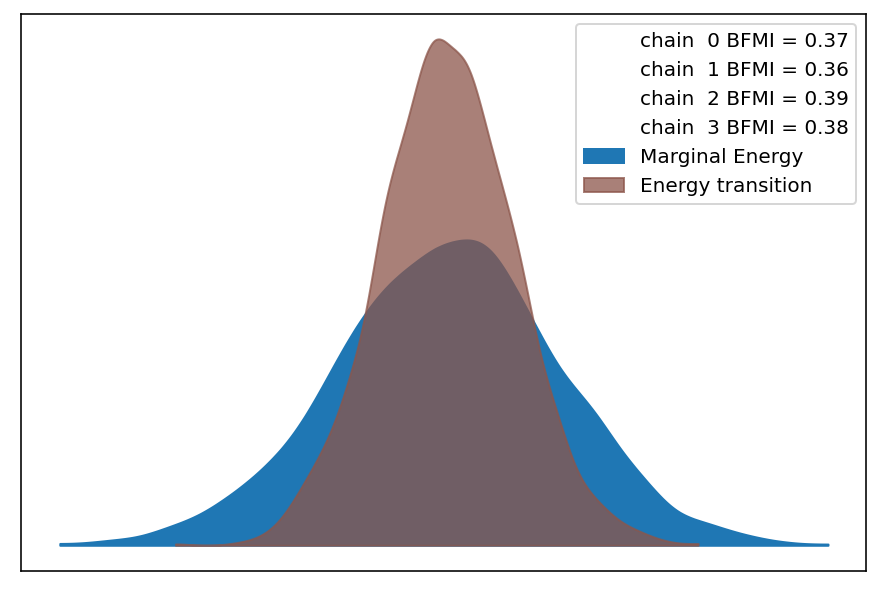

sbc-perm56
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 49, 14, 38, 20
percent divergences: 4.9, 1.4, 3.8, 2.0
BFMI: 0.289, 0.282, 0.372, 0.249
avg. step size: 0.016, 0.009, 0.004, 0.005


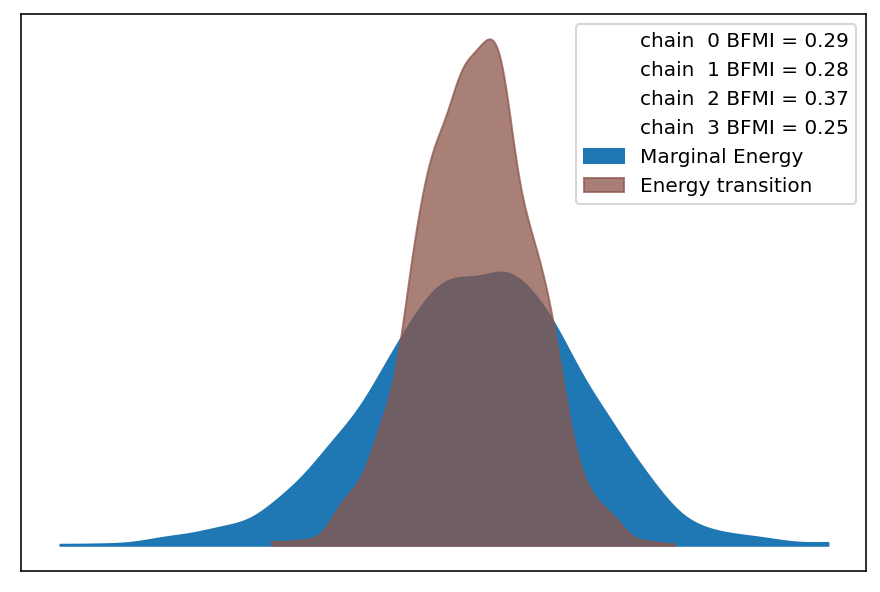

sbc-perm439
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 23, 15, 30, 3
percent divergences: 2.3, 1.5, 3.0, 0.3
BFMI: 0.317, 0.468, 0.428, 0.333
avg. step size: 0.014, 0.018, 0.014, 0.003


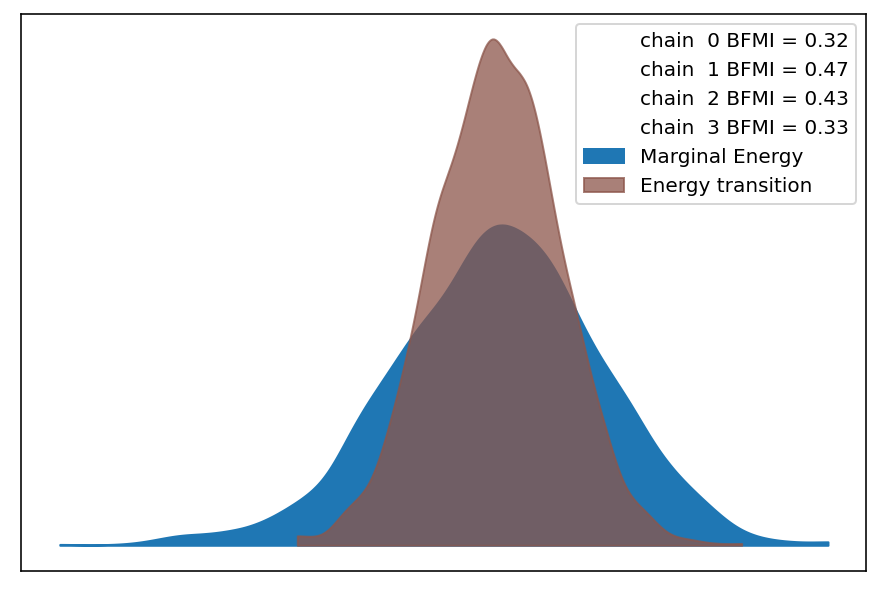

sbc-perm67
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 55, 169, 124, 0
percent divergences: 5.5, 16.9, 12.4, 0.0
BFMI: 0.331, 0.243, 0.383, 0.347
avg. step size: 0.015, 0.006, 0.003, 0.006


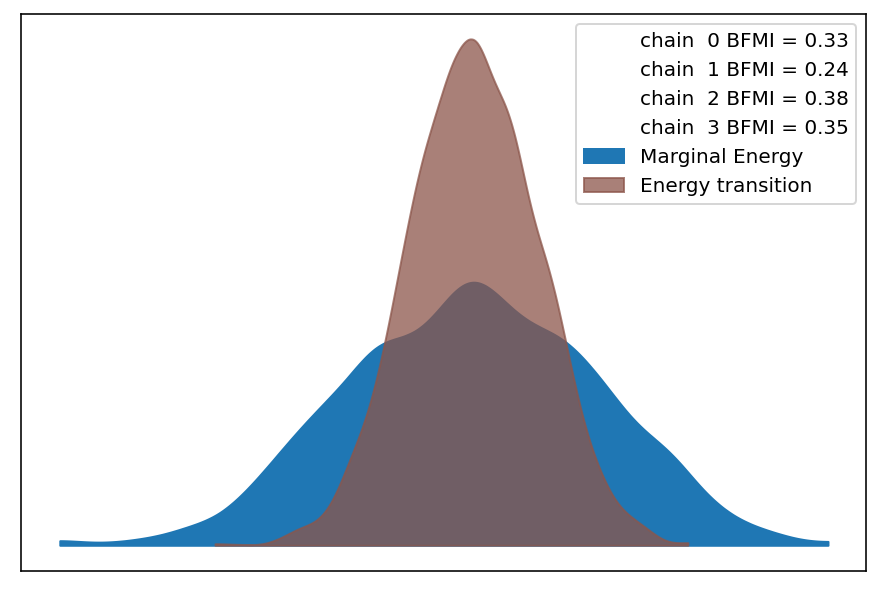

sbc-perm417
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 32, 12, 35, 106
percent divergences: 3.2, 1.2, 3.5, 10.6
BFMI: 0.278, 0.365, 0.308, 0.302
avg. step size: 0.008, 0.018, 0.019, 0.011


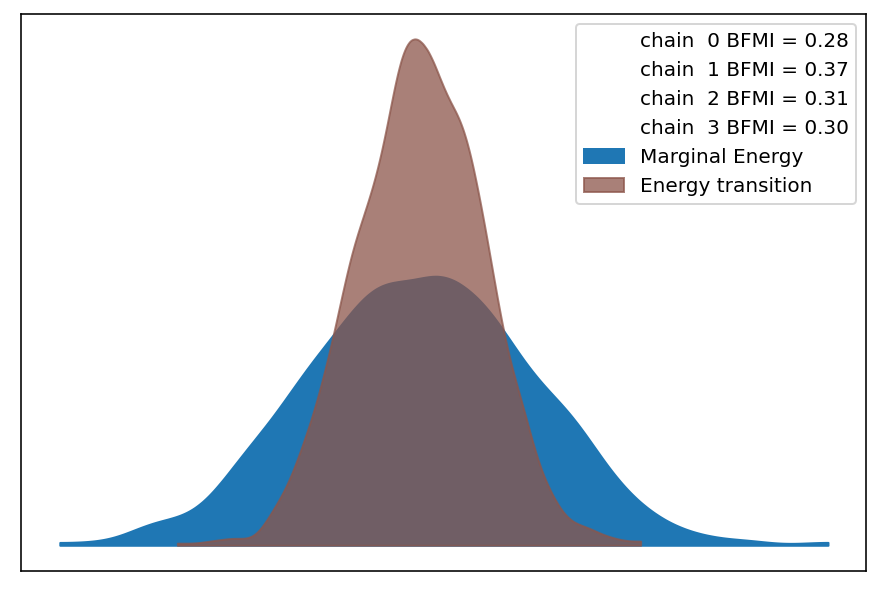

In [12]:
class IncompleteCachedResultsWarning(UserWarning):
    pass


if FIT_METHOD is ModelFitMethod.MCMC:
    pprint(sbc_analyzer.mcmc_diagnostics())
    print("=" * 60)

    all_sbc_perm_dirs = list(sbc_results_dir.iterdir())
    for perm_dir in np.random.choice(
        all_sbc_perm_dirs, size=min([5, len(all_sbc_perm_dirs)]), replace=False
    ):
        print(perm_dir.name)
        print("-" * 30)
        sbc_fm = sbc.SBCFileManager(perm_dir)
        if sbc_fm.all_data_exists():
            sbc_res = sbc_fm.get_sbc_results()
            _ = pmanal.describe_mcmc(sbc_res.inference_obj)
        else:
            warnings.warn(
                "Cannot find all components of the SBC results.",
                IncompleteCachedResultsWarning,
            )

### Estimate accuracy

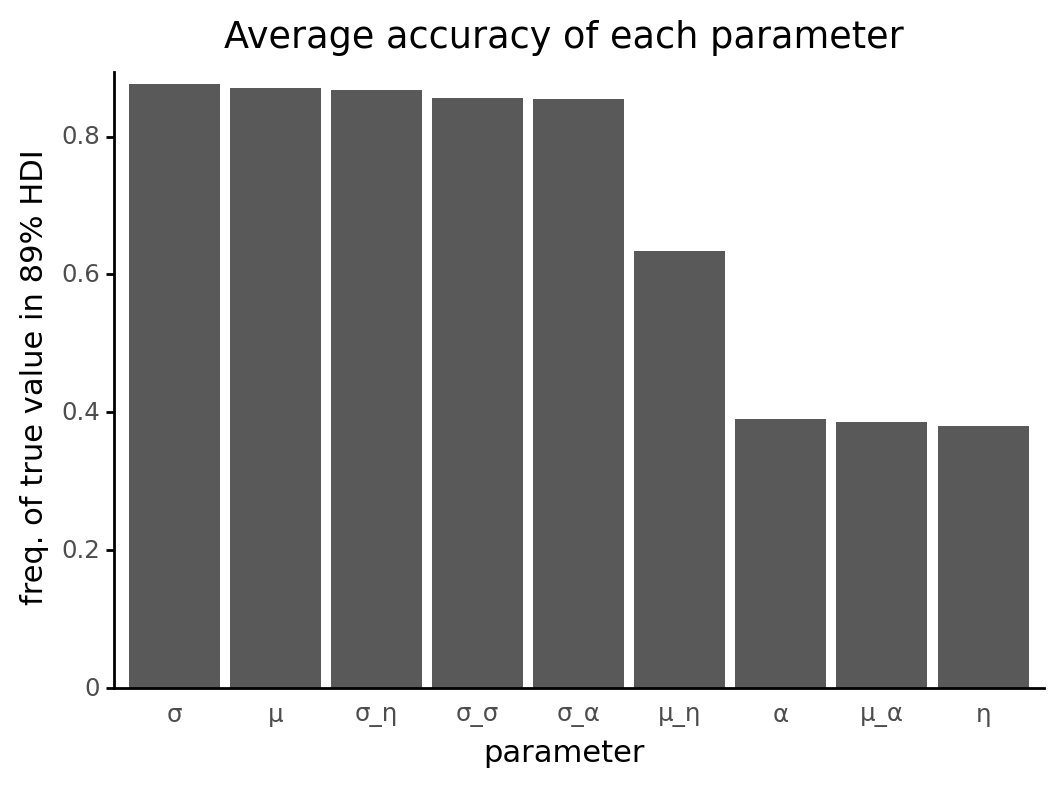

<ggplot: (2990064714734)>

In [13]:
accuracy_per_parameter = sbc_analyzer.run_posterior_accuracy_test()

accuracy_per_parameter["parameter_name"] = pd.Categorical(
    accuracy_per_parameter["parameter_name"],
    categories=accuracy_per_parameter["parameter_name"].values,
)

(
    gg.ggplot(accuracy_per_parameter, gg.aes(x="parameter_name", y="within_hdi"))
    + gg.geom_col()
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(
        x="parameter",
        y="freq. of true value in 89% HDI",
        title="Average accuracy of each parameter",
    )
    + gg.theme(axis_ticks_major_x=gg.element_blank(), figure_size=(6, 4))
)

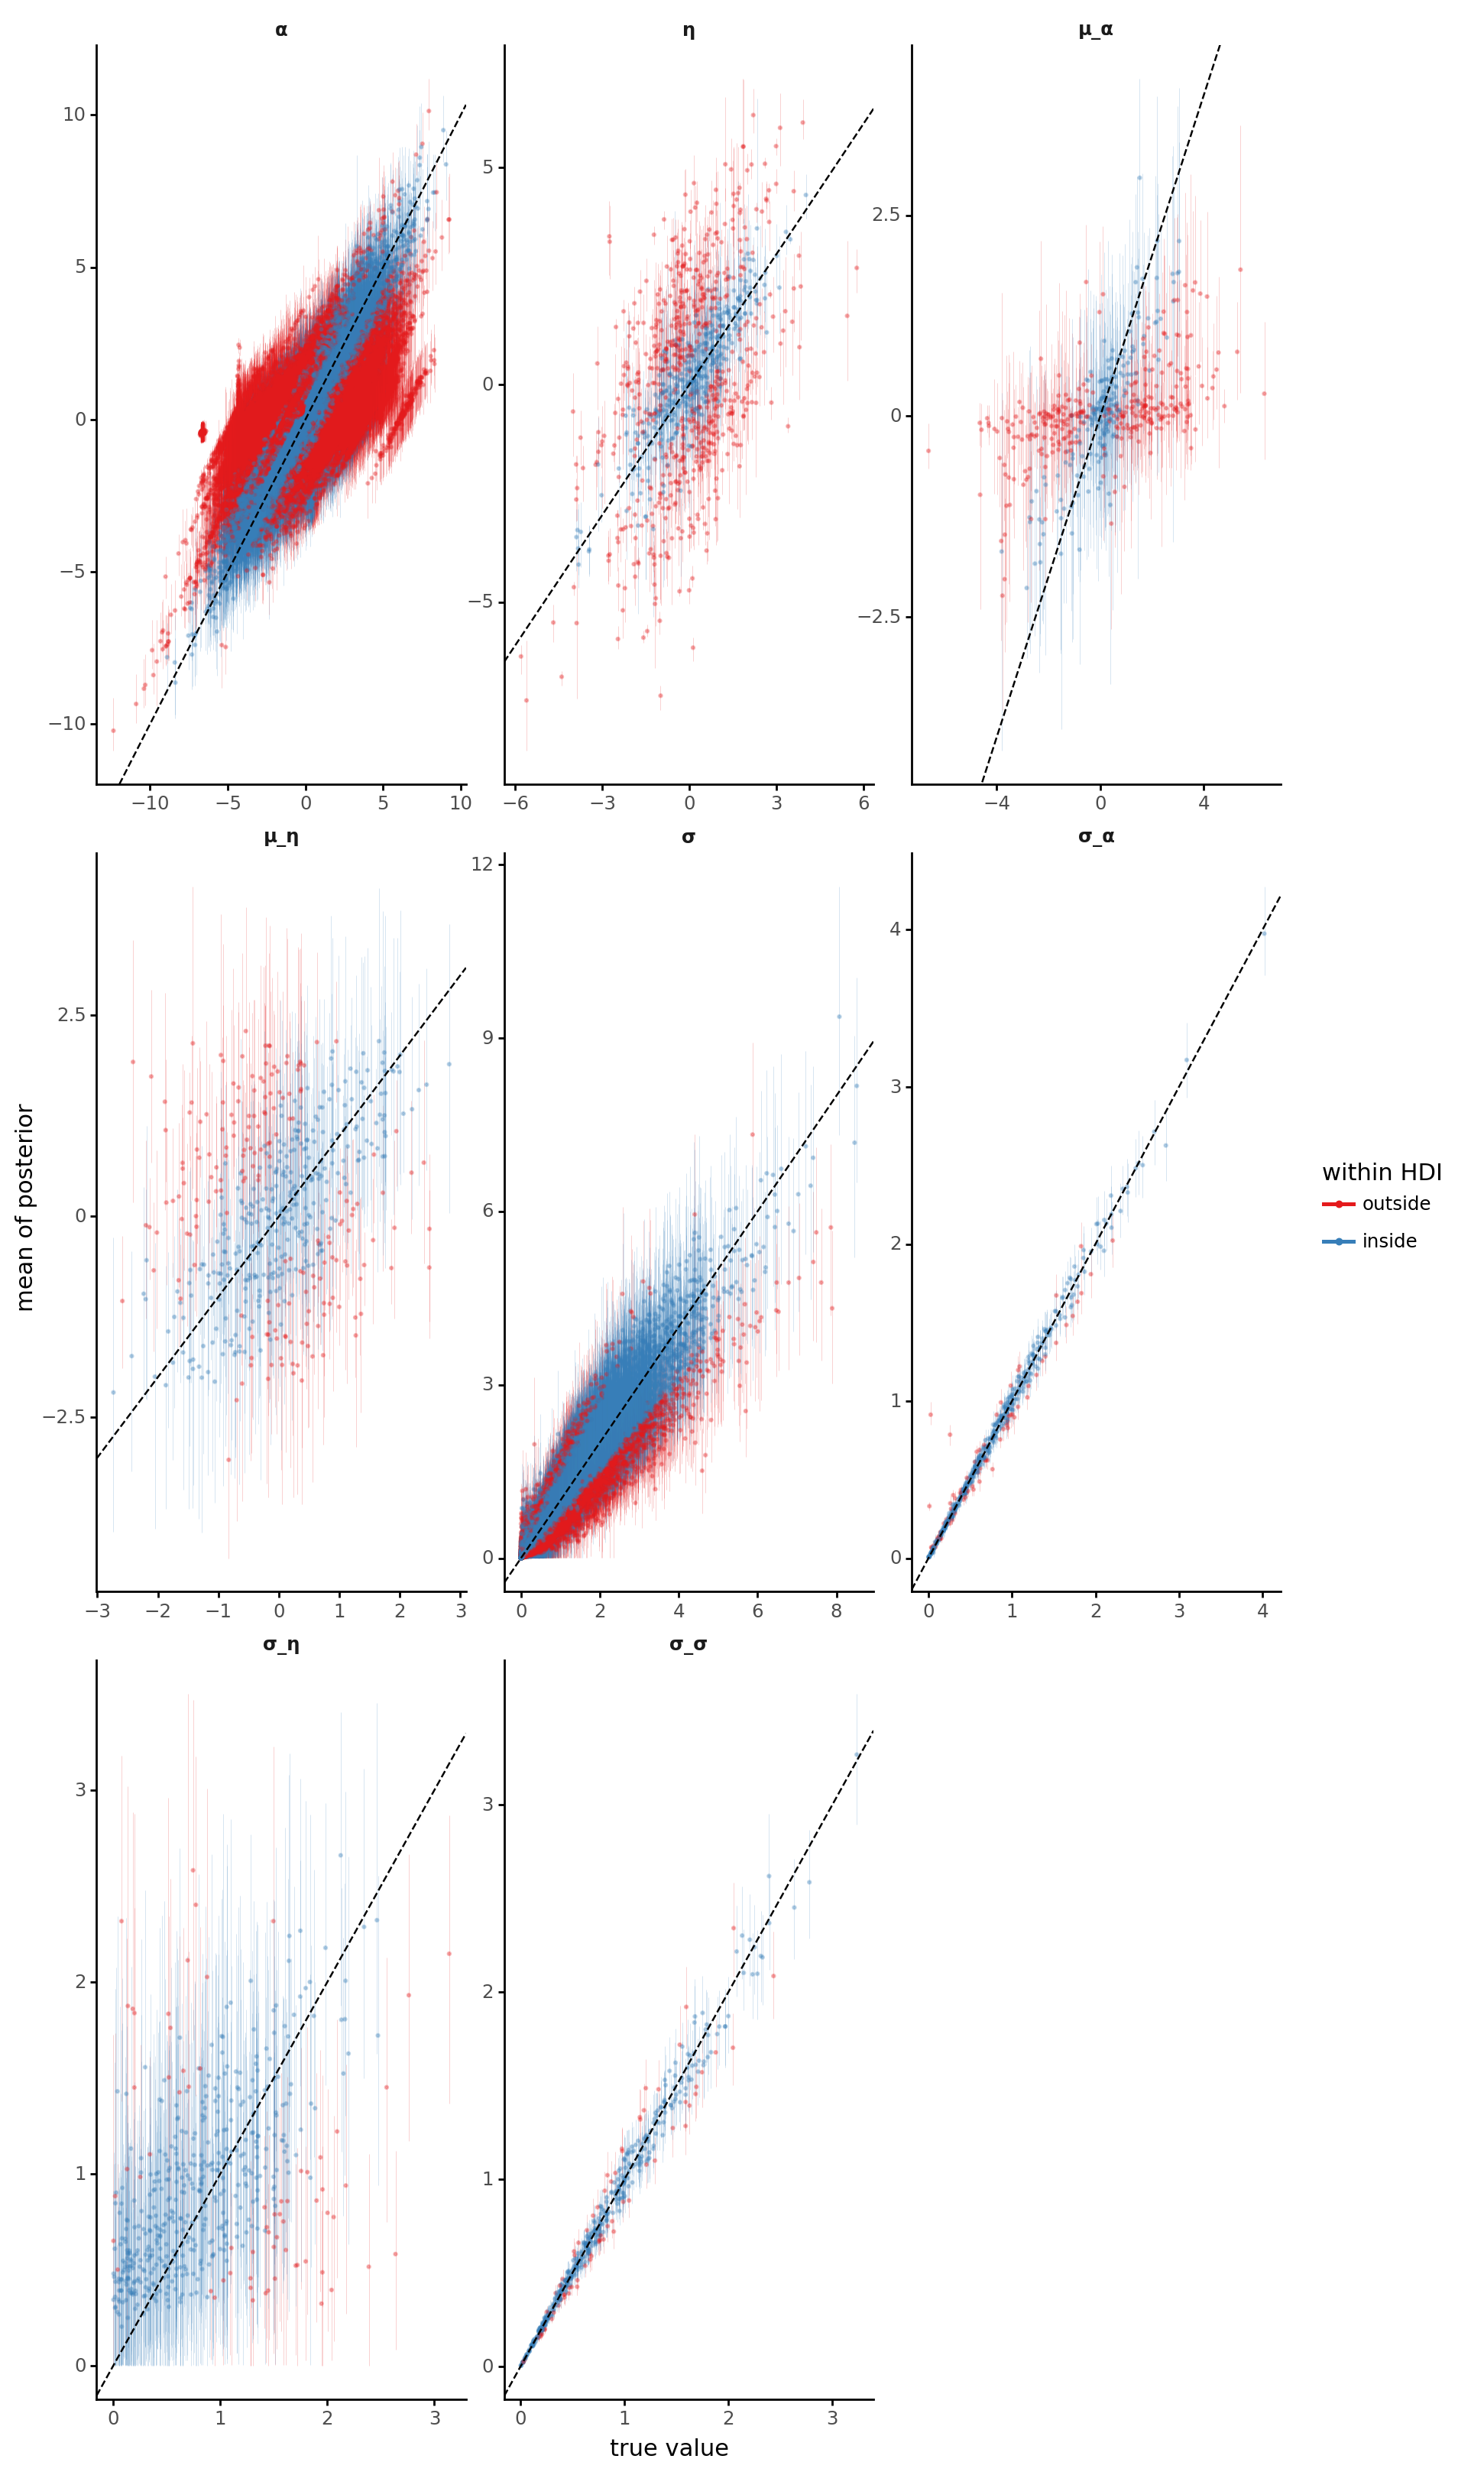

<ggplot: (2990053554902)>

In [14]:
hdi_low, hdi_high = pmanal.get_hdi_colnames_from_az_summary(simulation_posteriors_df)


def filter_uninsteresting_parameters(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.reset_index(drop=False)
        .query("parameter_name != 'μ'")
        .filter_string("parameter_name", search_string="offset", complement=True)
    )


(
    gg.ggplot(
        filter_uninsteresting_parameters(simulation_posteriors_df),
        gg.aes(x="true_value", y="mean", color="within_hdi"),
    )
    + gg.facet_wrap("~ parameter_name", ncol=3, scales="free")
    + gg.geom_linerange(gg.aes(ymin=hdi_low, ymax=hdi_high), alpha=0.2, size=0.2)
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.geom_abline(slope=1, intercept=0, linetype="--")
    + gg.scale_color_brewer(
        type="qual",
        palette="Set1",
        labels=("outside", "inside"),
        guide=gg.guide_legend(
            title="within HDI",
            override_aes={"alpha": 1, "size": 1},
        ),
    )
    + gg.theme(
        figure_size=(10, 20),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
        panel_spacing=0.25,
    )
    + gg.labs(
        x="true value",
        y="mean of posterior",
    )
)

### SBC Uniformity Test

In [15]:
var_names_to_plot = (
    sbc_uniformity_test[["parameter", "parameter_name"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .sort_values(["parameter_name", "parameter"])
    .groupby("parameter_name")
    .head(3)
    .reset_index(drop=True)
    .parameter.tolist()
)

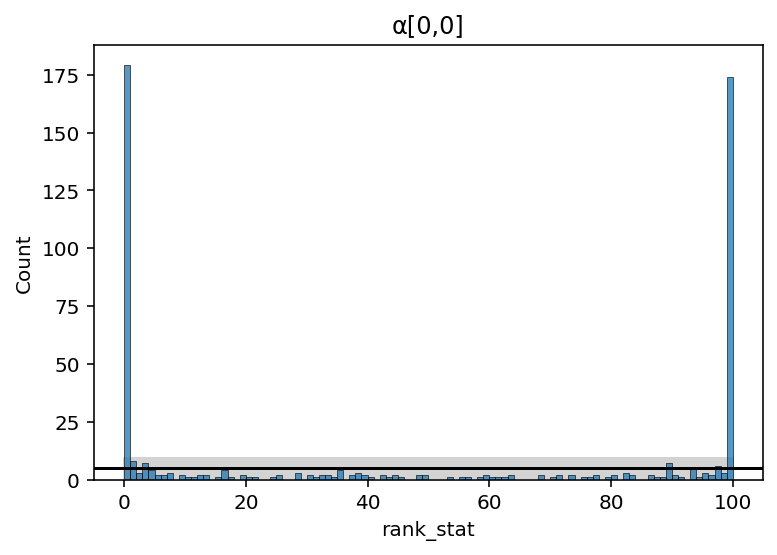

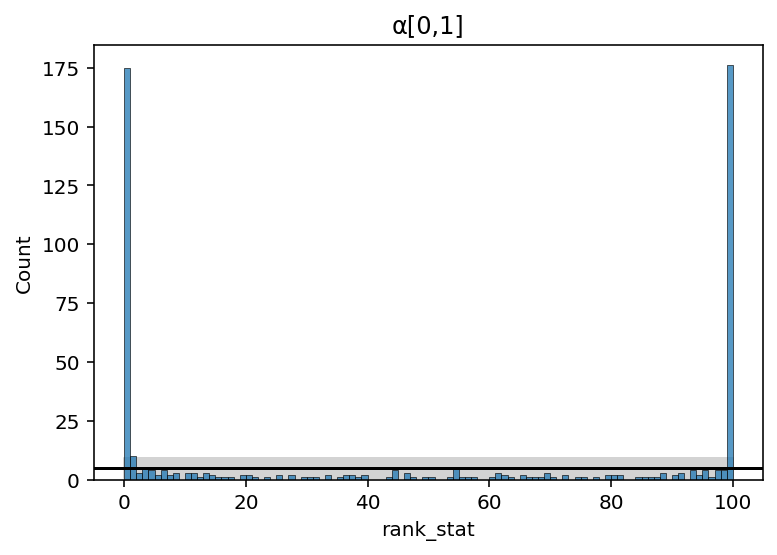

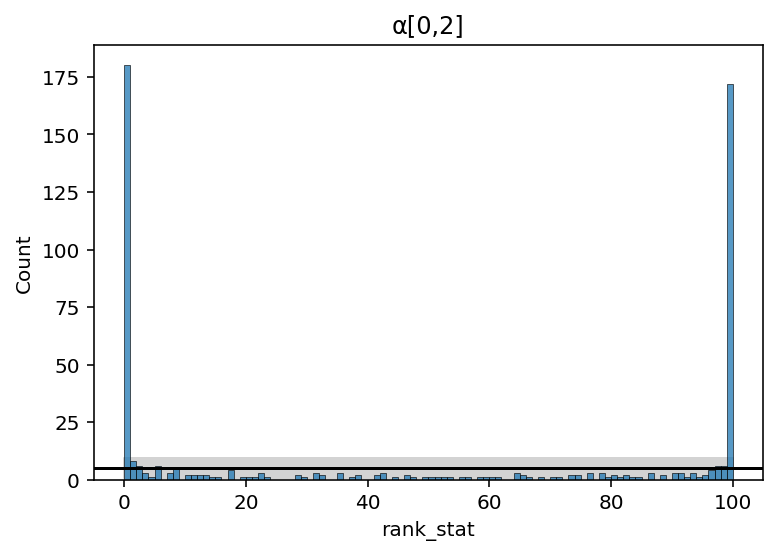

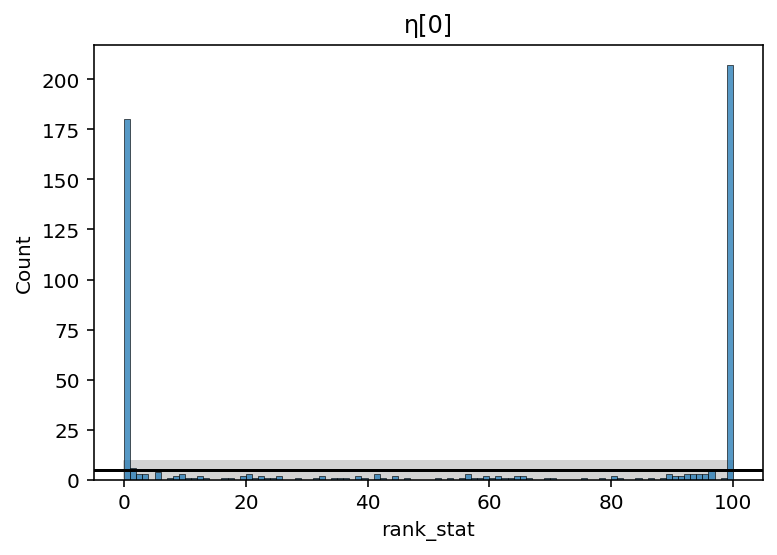

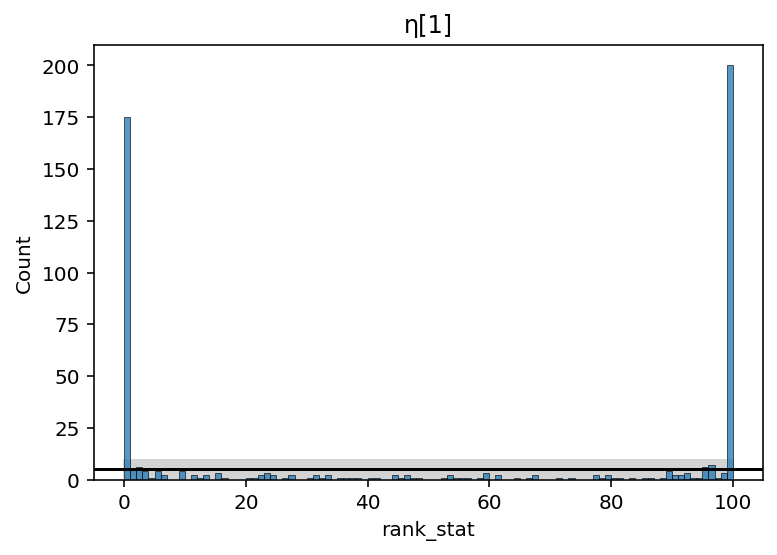

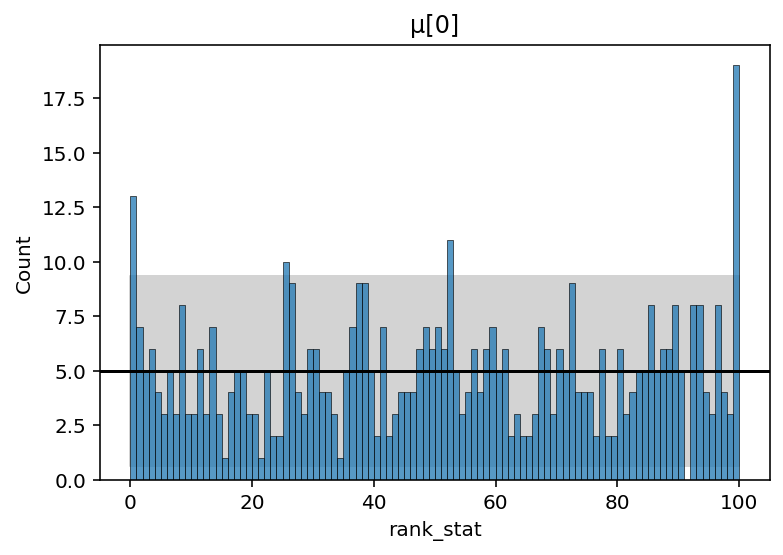

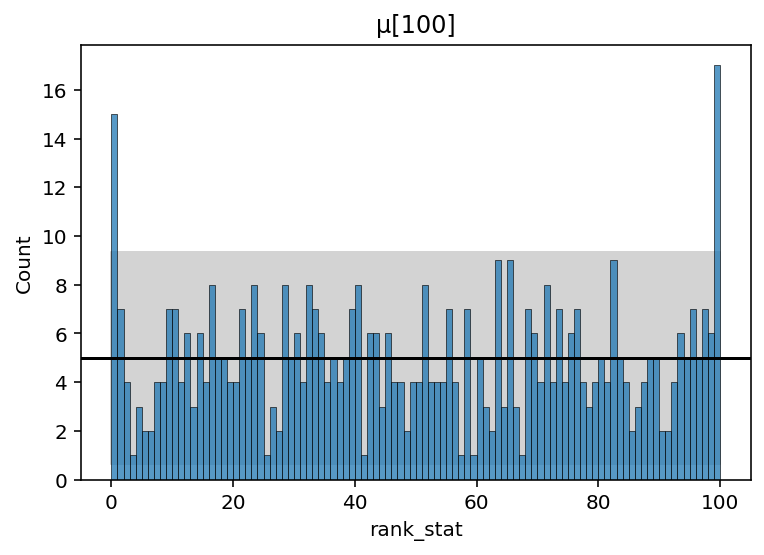

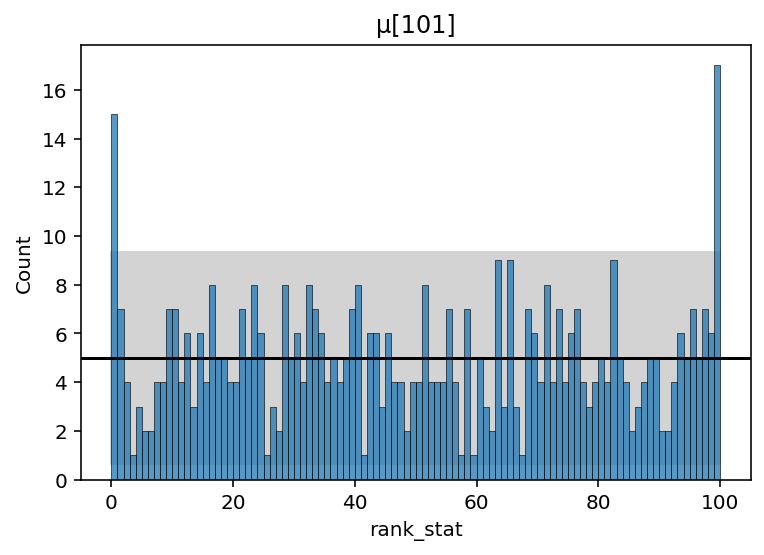

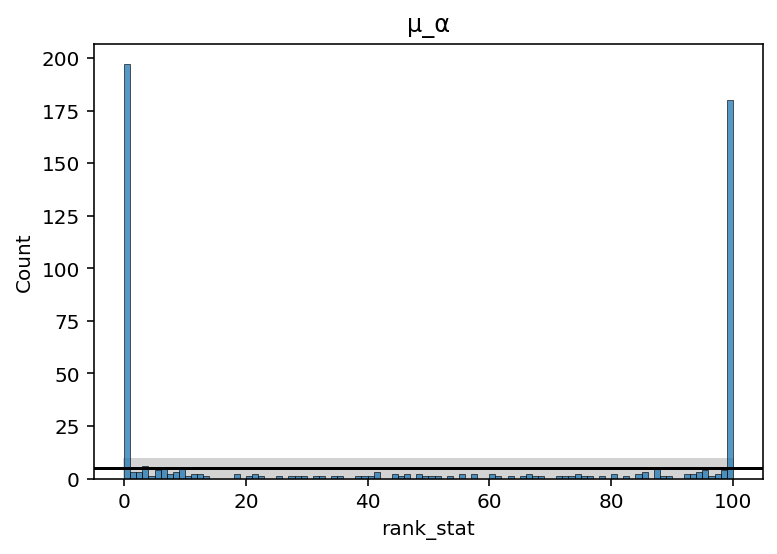

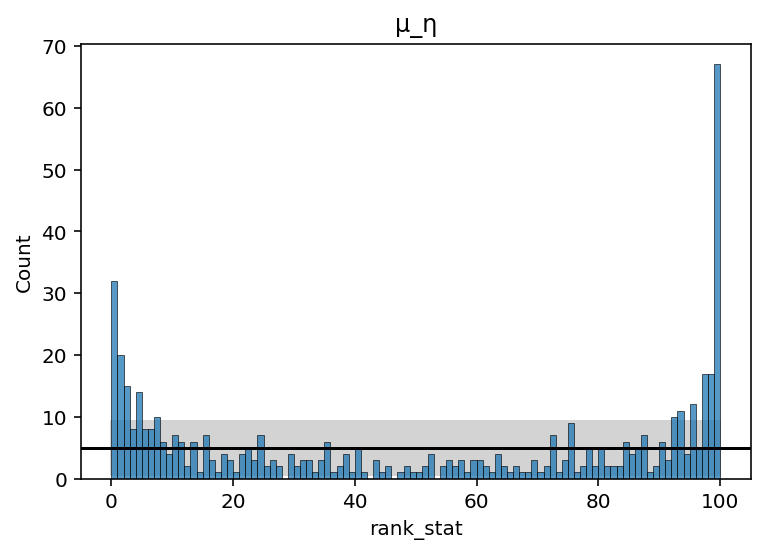

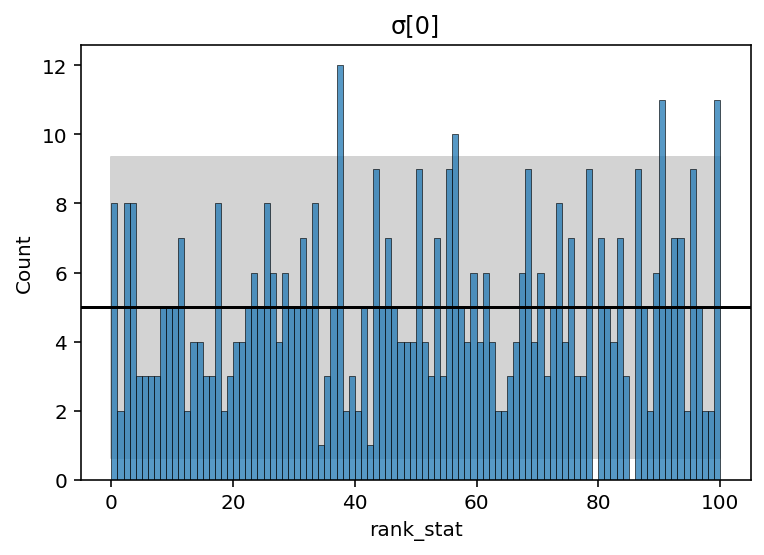

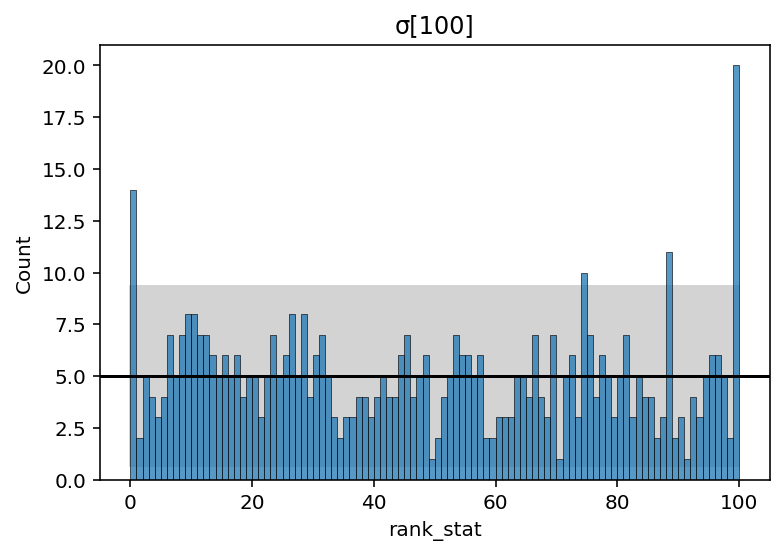

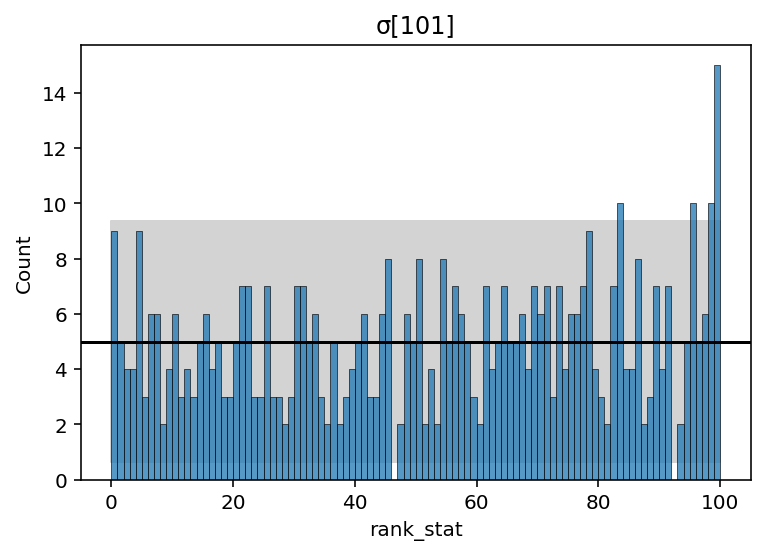

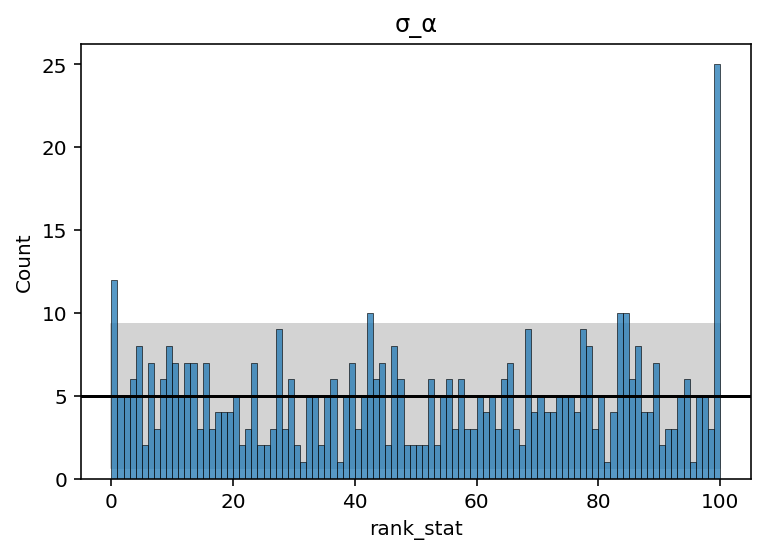

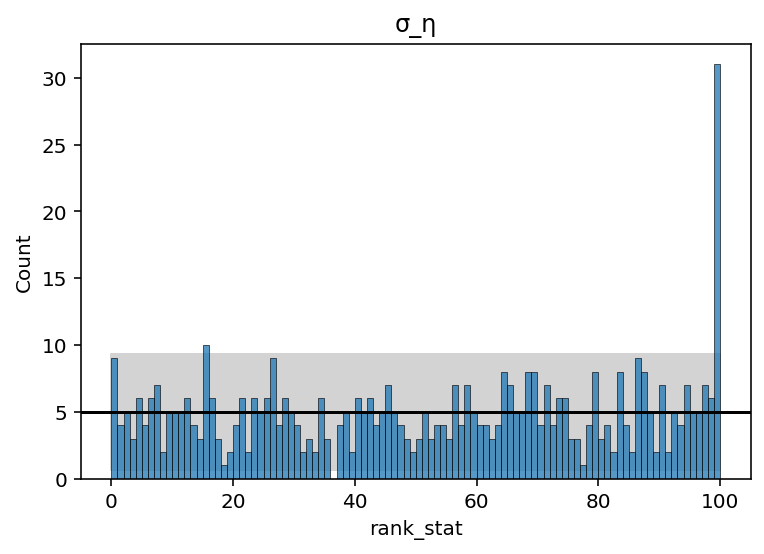

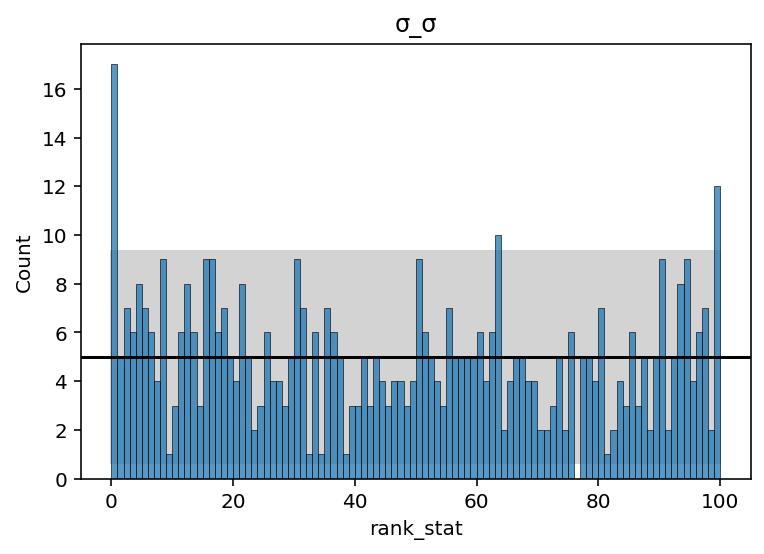

In [16]:
for v in var_names_to_plot:
    ax = sbc_analyzer.plot_uniformity(sbc_uniformity_test.query(f"parameter == '{v}'"))
    ax.set_title(v)
    plt.show()

---

In [17]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 5.60 minutes


In [18]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-08-12

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-238.o2.rc.hms.harvard.edu

Git branch: sbc-uniform-check

pandas    : 1.2.3
logging   : 0.5.1.2
janitor   : 0.20.14
plotnine  : 0.7.1
numpy     : 1.20.1
matplotlib: 3.3.4

